# **Ahmet Selçuk KÜREN Staj Çalışmaları**

## **Feature Engineering Nedir?**

Özellik mühendisliği, makine öğrenimi sürecini kolaylaştırmaya yardımcı olan ham verilerden yeni özellikler oluşturarak makine öğrenmesi algoritmalarının tahmin gücünü artırır ve daha iyi sonuçlar elde edilmesini sağlar.
### 1. Outliers (Aykırı Değerler)
 Aykırı Değerleri Yakalama

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [24]:
def load():
    data = pd.read_csv("titanic.csv")
    return data

In [25]:
df = load()
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


Grafik Teknikle Aykırı Değerler

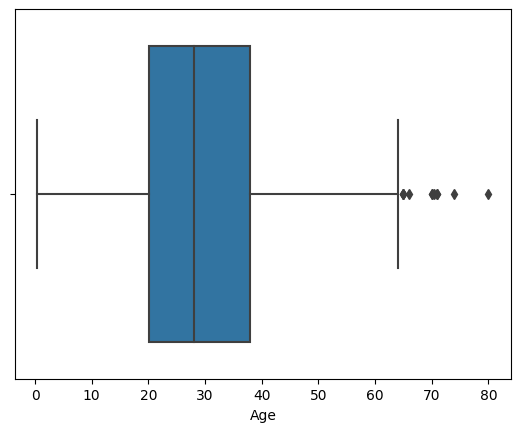

In [26]:
sns.boxplot(x=df["Age"])
plt.show()

Aykırı Değerler Nasıl Yakalanır?

In [27]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr

df[(df["Age"] < low) | (df["Age"] > up)]

df[(df["Age"] < low) | (df["Age"] > up)].index

Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [28]:
# Aykırı Değer Var mı Yok mu?
###################

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None)
df[(df["Age"] < low)].any(axis=None)

# 1. Eşik değer belirledik.
# 2. Aykırılara eriştik.
# 3. Hızlıca aykırı değer var mı yok diye sorduk.

False

İşlemleri Fonksiyonlaştırmak

In [29]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df, "Age")
outlier_thresholds(df, "Fare")

low, up = outlier_thresholds(df, "Fare")

df[(df["Fare"] < low) | (df["Fare"] > up)].head()


df[(df["Fare"] < low) | (df["Fare"] > up)].index

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [30]:
check_outlier(df, "Age")
check_outlier(df, "Fare")

True

**grab_col_names**

Bu fonksiyon Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

In [32]:
def grab_col_names(dataframe, cat_th=10, car_th=20):


  # cat_cols, cat_but_car
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                  dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                  dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  # num_cols
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

**Boxstring**: Fonksiyonların kullanım şeklini ve amacını açıklayan kısımdır.

grab_col_names fonksiyonunun boxstringi.

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

In [33]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

for col in num_cols:
    print(col, check_outlier(df, col))

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True


Aykırı Değerlerin Kendilerine Erişmek

In [34]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [35]:
grab_outliers(df, "Age")

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


# Aykırı Değer Problemini Çözme
Silme

In [36]:
low, up = outlier_thresholds(df, "Fare")
df.shape

df[~((df["Fare"] < low) | (df["Fare"] > up))].shape

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [37]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]


for col in num_cols:
    new_df = remove_outlier(df, col)


Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


Baskılama Yöntemi (re-assignment with thresholds)

In [38]:
low, up = outlier_thresholds(df, "Fare")

df[((df["Fare"] < low) | (df["Fare"] > up))]["Fare"]

df.loc[((df["Fare"] < low) | (df["Fare"] > up)), "Fare"]

df.loc[(df["Fare"] > up), "Fare"] = up

df.loc[(df["Fare"] < low), "Fare"] = low

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [39]:
# Recap
outlier_thresholds(df, "Age")
check_outlier(df, "Age")
grab_outliers(df, "Age", index=True)

remove_outlier(df, "Age").shape
replace_with_thresholds(df, "Age")
check_outlier(df, "Age")


     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


False

# Encoding (Label Encoding, One-Hot Encoding, Rare Encoding)
Veri bilimi ve makine öğrenimi süreçlerinde, veri setlerinde bulunan kategorik değişken türlerinin (yazılar, cümleler gibi text/string formatında olan veriler) makinelerin anlayabileceği bir formatta yeniden yazmaya Encoding denir

# Label Encoding
Bir kategorik değişkenin sınıfları labellardır. Label encoding bu sınıfları modellerde daha kullanışlı ve modellerin anlayabileceği hale getirecek şekilde kodlama yöntemlerinden biridir.

In [46]:
df["Sex"].head()

le = LabelEncoder()
le.fit_transform(df["Sex"])[0:5]
le.inverse_transform([0, 1])

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [47]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

# One-Hot Encoding

One Hot Encoding, kategorik değişkenlerin ikili (binary) olarak temsil edilmesi anlamına gelmektedir. Bu işlem ilk önce kategorik değerlerin tamsayı değerleriyle eşlenmesini gerektirir. Daha sonra, her bir tamsayı değeri, 1 ile işaretlenmiş tamsayı indeksi dışında ki tüm değerleri   sıfır  olan bir ikili vektör olarak temsil edilir.

In [40]:
df["Embarked"].value_counts()

pd.get_dummies(df, columns=["Embarked"]).head()

pd.get_dummies(df, columns=["Embarked"], drop_first=True).head()

pd.get_dummies(df, columns=["Embarked"], dummy_na=True).head()

pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True).head()

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [48]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]


one_hot_encoder(df, ohe_cols).head()

,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Cabin,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",1,22.000,A/5 21171,7.250,NaN,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,PC 17599,65.634,C85,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",0,26.000,STON/O2. 3101282,7.925,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,113803,53.100,C123,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",1,35.000,373450,8.050,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Rare Encoding


1. Kategorik değişkenlerin azlık çokluk durumunun analiz edilmesi.
2. Rare kategoriler ile bağımlı değişken arasındaki ilişkinin analiz edilmesi.

In [49]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df
